# Importing Libraries

In [296]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
from fredapi import Fred
import scipy.stats as stats
from scipy.stats import f, chi2
import seaborn as sns
from tabulate import tabulate
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_white, het_breuschpagan, acorr_breusch_godfrey, acorr_ljungbox


In [6]:
import warnings
warnings.filterwarnings("ignore")

In [130]:
sns.set_style('whitegrid')

# Gathering Data


# a) & b)

a) Using https://finance.yahoo.com/cryptocurrencies, download the prices of 2 cryptocurrencies from September 2015 (or the oldest release) to August 2023 (in his- torical data). Tranform them adequately to have log return x 100 (rt=ln(Pt/Pt−1)x 100). Using the dataset maintained by Federal Reserve of St. Louis https://fred.stlouisfed.org/, download SP500 and risk free interest rate (FFR) for the same sample period.



In [8]:
cryptos = yf.download("BTC-USD ETH-USD")
cryptos = cryptos['Close']

start = pd.to_datetime('2015-08-31')
cutoff = pd.to_datetime('2023-08-31')

[*********************100%***********************]  2 of 2 completed


In [9]:
BTC = cryptos[['BTC-USD']]
ETH = cryptos[['ETH-USD']]

download SP500 and risk free interest rate (FFR) 

In [10]:
fred = Fred(api_key='yourkeyhere')

SP = pd.DataFrame(fred.get_series('SP500'))
SP = SP.rename(columns={0:"SP500"})

FFR = pd.DataFrame(fred.get_series('DFF'))
FFR = FFR.rename(columns={0:"FFR"})

In [11]:
BTC=BTC.merge(SP, left_index=True, right_index=True)
BTC=BTC.merge(FFR, left_index=True, right_index=True)

ETH=ETH.merge(SP, left_index=True, right_index=True)
ETH=ETH.merge(FFR, left_index=True, right_index=True)

In [12]:
def log_returns(df, crypto_name):
    for col in [crypto_name, 'SP500']:
        df[col] = np.log(df[col] / df[col].shift(1)) * 100 #log transform
    df = df.copy().loc[(df.index <= cutoff) & (df.index >= start)] #within relevant period
    df.dropna(axis=0, inplace=True)
    return df

BTC = log_returns(BTC, 'BTC-USD')
ETH = log_returns(ETH, 'ETH-USD')

# c)

In [13]:
def run_lin_reg(df, col, constant=True):
    #maybe move into helper function
    df['y_actual'] = df[col] - df['FFR']
    df['x'] = df['SP500'] - df['FFR']
    y = df['y_actual'] # potentially skip df[y_actual] step ?
    X = df['x']
    if constant == True:
        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        df['y_hat'] = model.predict(X)
        df['residual'] = df['y_hat'] - df['y_actual']
    elif constant == False:
        model = sm.OLS(y, X).fit()
        df['y_hat_no_const'] = model.predict(X)
        df['residual_no_const'] = df['y_hat'] - df['y_actual']
    print(f'Results for {col}:\n', model.summary())
    return model




BTC_model = run_lin_reg(BTC, 'BTC-USD')
ETH_model = run_lin_reg(ETH, 'ETH-USD')

Results for BTC-USD:
                             OLS Regression Results                            
Dep. Variable:               y_actual   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     367.2
Date:                Wed, 11 Oct 2023   Prob (F-statistic):           4.34e-75
Time:                        11:29:46   Log-Likelihood:                -5578.2
No. Observations:                1941   AIC:                         1.116e+04
Df Residuals:                    1939   BIC:                         1.117e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1682      0.1

In [132]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [363]:
def plot_reg_resid(crypto1, crypto2, robust = False, constant = True, save=True):
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

    for i, df in enumerate([crypto1, crypto2]):
        if robust == True:
            rbst = 'Robust ' #for titles
            const = ''
            y_hat = 'y_hat_robust'
            residual = 'residual_robust'
        elif constant == False:
            rbst = ''
            const = '(without constant)'
            y_hat = 'y_hat_no_const'
            residual = 'residual_no_const'
        else:
            rbst = ''
            const = ''
            y_hat = 'y_hat'
            residual = 'residual'

        row = 0

        col = i % 2
        # scatter plot    
        axes[row, col].scatter(df['x'], df['y_actual'], c = 'black',marker='.', s=5,alpha = 0.5, label = 'Data')
        # regression line
        axes[row, col].plot(df['x'], df[y_hat], color='red', linewidth=1, label='Regression Line')

        # titles and labels
        axes[row, col].set_title(f'Scatter Plot with {rbst}Regression Line {const} ({df.columns[0]})')
        axes[row, col].set_xlabel('x')
        axes[row, col].set_ylabel('Y')
        axes[row, col].legend()

    # histograms of residuals 
        row = 1  # Second row
        col = i   # Calculate column position
        
        axes[row, col].hist(df[residual], bins=50, color='gray', edgecolor='black', alpha=1, density=True, zorder=1)  # Normalize histogram

        # overlay normal dist. curve
        mu, std = df[residual].mean(), df[residual].std()
        x = np.linspace(df[residual].min(), df[residual].max(), 100)
        pdf = stats.norm.pdf(x, mu, std)
        axes[row, col].plot(x, pdf, color='black', alpha =0.7, label='Normal Distribution', zorder=2)

        axes[row, col].set_title(f'Histogram of Residuals ({df.columns[0]})')
        axes[row, col].set_xlabel('Residuals')
        axes[row, col].set_ylabel('Density') 
        axes[row, col].legend()
        
    plt.tight_layout()
    if save == True:
        if constant==True:
            plt.savefig(r"/Users/tomonuallain/Desktop/Final_Year/FIN30200/reg_resid_nonrobust.jpeg", dpi=300, bbox_inches='tight')    
        else:
            plt.savefig(r"/Users/tomonuallain/Desktop/Final_Year/FIN30200/reg_resid_nonrobust_noConstant.jpeg", dpi=300, bbox_inches='tight')    

    plt.show()

# plt.savefig(r"/Users/tomonuallain/Desktop/Final_Year/FIN30200")

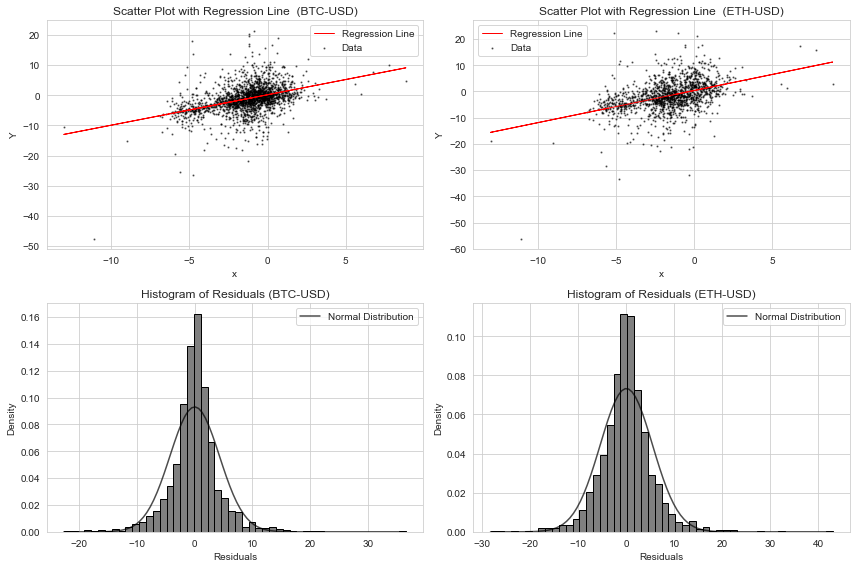

In [365]:
plot_reg_resid(BTC, ETH, save=True) 

In [16]:
def anderson_darling_test(crypto_name, residuals, significance_level=0.05):

    result = stats.anderson(residuals, dist='norm')

    # Extract test statistic, critical values, and significance levels
    test_statistic = result.statistic
    critical_values = result.critical_values
    significance_levels = result.significance_level

    # Find the critical value corresponding to your chosen significance level
    critical_value = None
    for i, alpha in enumerate(significance_levels):
        if alpha == significance_level*100:
            critical_value = critical_values[i]
            break
    
    # Check if the test statistic is less than the critical value at the chosen significance level
    exceeds_critical = test_statistic > critical_value
    text_1 = "exceeds" if exceeds_critical else "does not exceed"
    text_2 = "" if exceeds_critical else "not"
    print(f"Anderson-Darling Test for Normality ({crypto_name})")
    print("----------------------------------------")
    print(f"Test Statistic: {test_statistic:.4f}")
    print(f"Critical Value ({significance_level}): {critical_value:.4f}")
    print(f"The value of the statistic {text_1} the critical value, so for {crypto_name},\nthe null hypothesis may{text_2} be rejected (at {significance_level} significance level)")


In [17]:
anderson_darling_test('BTC', BTC['residual'])
anderson_darling_test('ETH', ETH['residual'])

Anderson-Darling Test for Normality (BTC)
----------------------------------------
Test Statistic: 38.6812
Critical Value (0.05): 0.7850
The value of the statistic exceeds the critical value, so for BTC,
the null hypothesis may be rejected (at 0.05 significance level)
Anderson-Darling Test for Normality (ETH)
----------------------------------------
Test Statistic: 17.9303
Critical Value (0.05): 0.7850
The value of the statistic exceeds the critical value, so for ETH,
the null hypothesis may be rejected (at 0.05 significance level)


**Test for serial correlation**

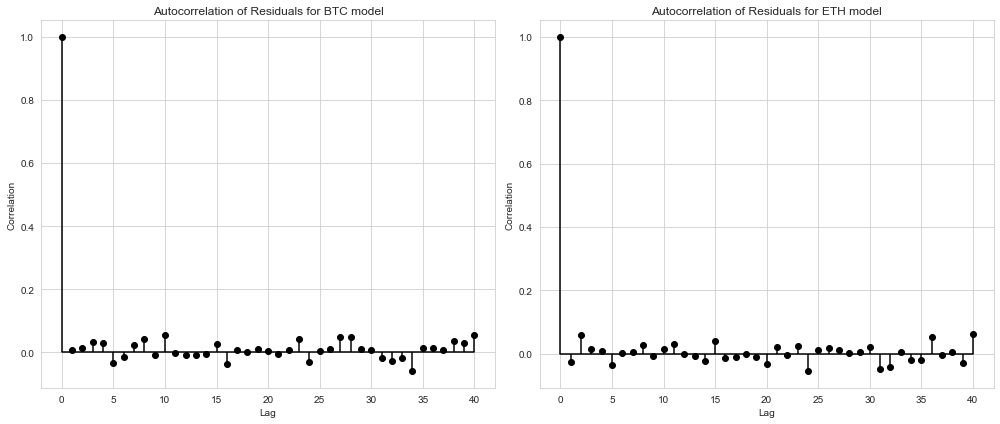

In [366]:
def acf_chart(crypto_name1, residuals1, crypto_name2, residuals2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # calculate the autocorrelation function 
    acf_result1 = sm.tsa.acf(residuals1, fft=True)
    ax1.stem(range(len(acf_result1)), acf_result1, basefmt='black', linefmt='black', markerfmt='ko')

    ax1.set_title(f"Autocorrelation of Residuals for {crypto_name1} model")
    ax1.set_xlabel("Lag")
    ax1.set_ylabel("Correlation")

    acf_result2 = sm.tsa.acf(residuals2, fft=True)
    ax2.stem(range(len(acf_result2)), acf_result2, basefmt='black', linefmt='black', markerfmt='ko')

    ax2.set_title(f"Autocorrelation of Residuals for {crypto_name2} model")
    ax2.set_xlabel("Lag")
    ax2.set_ylabel("Correlation")


    plt.tight_layout()
    plt.show()
    
acf_chart("BTC", BTC['residual'], "ETH", ETH['residual'])


examination of the above charts would not lead one to believe there is much autocorrelation

In [22]:
def breusch_godfrey_test(crypto_name, residuals, lags=None):
   
    # Breusch-Godfrey test
    test_results = acorr_breusch_godfrey(residuals, nlags=lags)

    LM_statistic = test_results[0]
    p_value = test_results[1]
    print(f"The {crypto_name} model has an LM statistic of {round(LM_statistic, 2)}, which corresponds to a p-value of {round(p_value, 2)}")
    return LM_statistic, p_value

breusch_godfrey_test('BTC', BTC_model)
breusch_godfrey_test('ETH', ETH_model)





The BTC model has an LM statistic of 26.64, which corresponds to a p-value of 0.37
The ETH model has an LM statistic of 16.59, which corresponds to a p-value of 0.83


(16.59283879908361, 0.8287414663719603)

In [23]:
def ljung_box_test(ts_data, lags=20):
    # perform the test
    lb_test_results = acorr_ljungbox(ts_data, lags=lags)

    test_statistics = lb_test_results[0]
    p_values = lb_test_results[1]

    # table with the results
    results_table = []
    for lag, test_statistic, p_value in zip(range(1, lags + 1), test_statistics, p_values):
        results_table.append([lag, test_statistic, p_value])

    # print table
    headers = ["Lag", "Test Statistic", "p-value"]
    print(tabulate(results_table, headers, tablefmt="fancy_grid"))

    return test_statistics, p_values

ljung_box_test(BTC['residual'])

╒═══════╤══════════════════╤═══════════╕
│   Lag │   Test Statistic │   p-value │
╞═══════╪══════════════════╪═══════════╡
│     1 │         0.076675 │ 0.781855  │
├───────┼──────────────────┼───────────┤
│     2 │         0.470143 │ 0.790514  │
├───────┼──────────────────┼───────────┤
│     3 │         2.42894  │ 0.48827   │
├───────┼──────────────────┼───────────┤
│     4 │         3.99538  │ 0.406631  │
├───────┼──────────────────┼───────────┤
│     5 │         6.12175  │ 0.294552  │
├───────┼──────────────────┼───────────┤
│     6 │         6.61074  │ 0.358349  │
├───────┼──────────────────┼───────────┤
│     7 │         7.59896  │ 0.369281  │
├───────┼──────────────────┼───────────┤
│     8 │        11.2574   │ 0.187539  │
├───────┼──────────────────┼───────────┤
│     9 │        11.3707   │ 0.25115   │
├───────┼──────────────────┼───────────┤
│    10 │        17.0411   │ 0.0734589 │
├───────┼──────────────────┼───────────┤
│    11 │        17.0502   │ 0.1064    │
├───────┼───────

(array([ 0.07667498,  0.47014348,  2.42893915,  3.99538419,  6.12174521,
         6.61074358,  7.59895537, 11.25736347, 11.37073263, 17.04112529,
        17.05018435, 17.18699101, 17.31378768, 17.36879297, 18.75447873,
        21.37070716, 21.5016835 , 21.50174123, 21.70459307, 21.72818176]),
 array([0.78185499, 0.79051414, 0.48827034, 0.40663089, 0.29455222,
        0.3583488 , 0.36928108, 0.18753869, 0.25115035, 0.07345892,
        0.10639988, 0.14269769, 0.1853537 , 0.23705699, 0.22507609,
        0.16469713, 0.20465   , 0.25485895, 0.29920393, 0.35544053]))

**Testing for Heteroskedasticity**

Plot of residuals vs fitted values to test for hetersoskedasticity
- verify the assumption that the residuals are randomly distributed and have constant variance

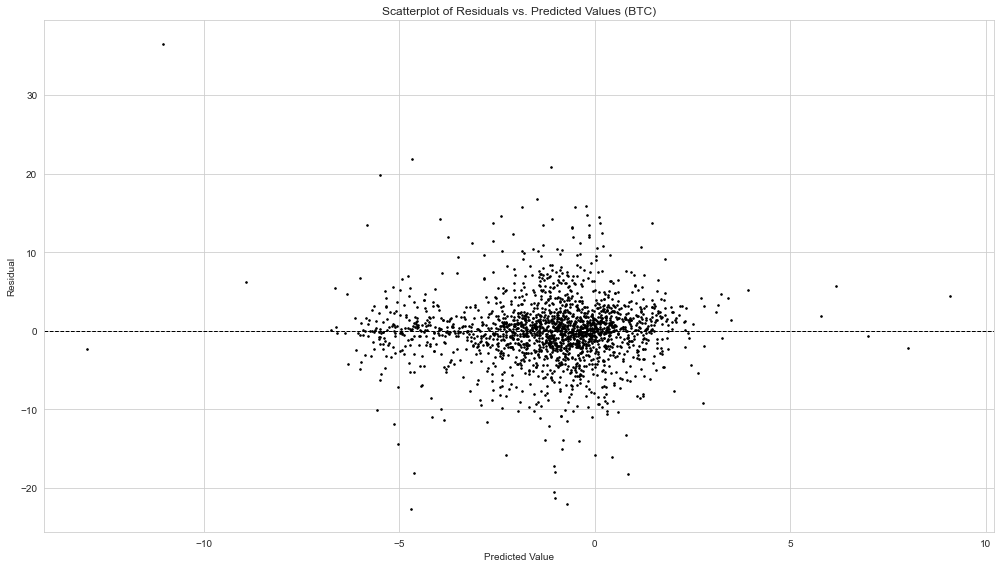

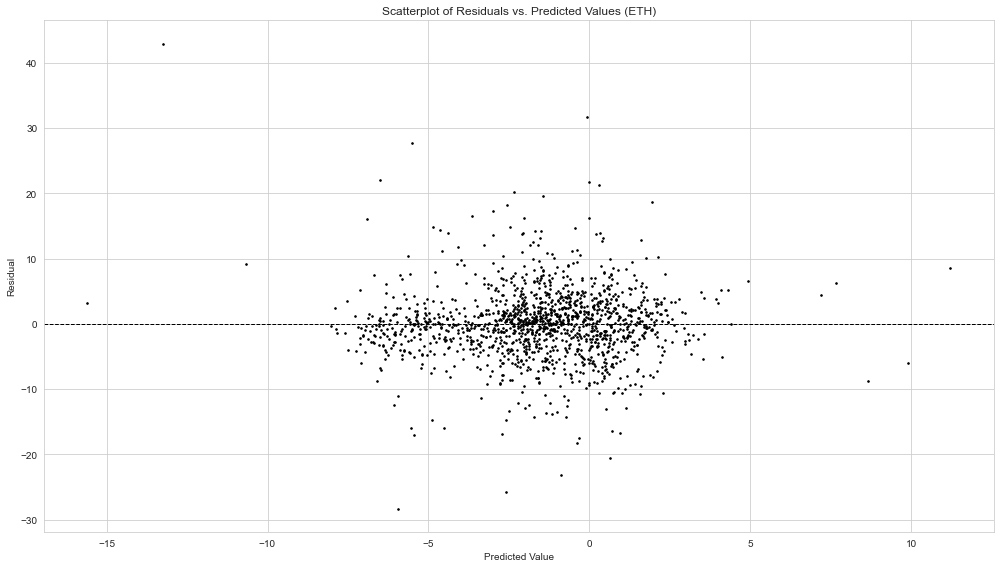

In [367]:
def plot_residuals_fitted_vals(crypto_name, predicted, residuals):
    
    # scatterplot
    plt.figure(figsize=(14, 8))
    plt.scatter(predicted, residuals, marker='.', color='black', alpha=1, s=10)

    # labels and a title
    plt.xlabel("Predicted Value")
    plt.ylabel("Residual")
    plt.title(f"Scatterplot of Residuals vs. Predicted Values ({crypto_name})")

    # horizontal line at y=0 for reference
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

    plt.tight_layout()
    plt.savefig(f"//Users//tomonuallain//Desktop//Final_Year//FIN30200//resid_pred_{crypto_name}.jpeg", dpi=300, bbox_inches='tight')    
    plt.show()

plot_residuals_fitted_vals('BTC', BTC['y_hat'], BTC['residual'])
plot_residuals_fitted_vals('ETH', ETH['y_hat'], ETH['residual'])

**White test**

In [25]:
def white_test(crypto_name, crypto_model, df, residuals):

    # perform the White test
    exog = crypto_model.model.exog

    white_test_result = het_white(residuals, exog)

    test_statistic = white_test_result[0]
    p_value = white_test_result[1]
    
    print(f"White Test for Heteroskedasticity ({crypto_name})")
    print("---------------------------------------")
    print(f"Test Statistic: {test_statistic:.4f}")
    print(f"P-Value: {p_value:.4f}\n\n")

    return test_statistic, p_value

white_test('BTC', BTC_model, BTC, BTC['residual'])
white_test('ETH', ETH_model, ETH, ETH['residual'])


White Test for Heteroskedasticity (BTC)
---------------------------------------
Test Statistic: 51.9855
P-Value: 0.0000


White Test for Heteroskedasticity (ETH)
---------------------------------------
Test Statistic: 41.2578
P-Value: 0.0000




(41.25780575391694, 1.0989585515201661e-09)

In [26]:
def breusch_pagan_test(crypto_name, crypto_model, df, residuals):
    exog = crypto_model.model.exog

    # perform the Breusch-Pagan test
    bp_test_result = het_breuschpagan(residuals, exog, robust=False)

    test_statistic = bp_test_result[0]
    p_value = bp_test_result[1]

    print(f"Breusch-Pagan Test for Heteroskedasticity ({crypto_name})")
    print("-----------------------------------------------")
    print(f"Test Statistic: {test_statistic:.8f}")
    print(f"P-Value: {p_value:.4f}")

    
breusch_pagan_test('BTC', BTC_model, BTC, BTC['residual'])
breusch_pagan_test('ETH', ETH_model, ETH, ETH['residual'])


Breusch-Pagan Test for Heteroskedasticity (BTC)
-----------------------------------------------
Test Statistic: 65.72110376
P-Value: 0.0000
Breusch-Pagan Test for Heteroskedasticity (ETH)
-----------------------------------------------
Test Statistic: 29.47135347
P-Value: 0.0000


# d) 

In [27]:
def run_lin_reg_robust_se(df, col, const=True):

    y = df['y_actual'] # potentially skip df[y_actual] step ?
    X = df['x']
    if const == True:
        X = sm.add_constant(X)
    new_model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':12, 'use_correction':True})
    df['y_hat_robust'] = new_model.predict(X)
    df['residual_robust'] = df['y_hat_robust'] - df['y_actual']
    print(f'\n\nResults for {col}:\n\n', new_model.summary())
    return new_model

BTC_model_robust = run_lin_reg_robust_se(BTC, 'BTC-USD')
ETH_model_robust = run_lin_reg_robust_se(ETH, 'ETH-USD')



Results for BTC-USD:

                             OLS Regression Results                            
Dep. Variable:               y_actual   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     222.1
Date:                Wed, 11 Oct 2023   Prob (F-statistic):           1.25e-47
Time:                        11:29:55   Log-Likelihood:                -5578.2
No. Observations:                1941   AIC:                         1.116e+04
Df Residuals:                    1939   BIC:                         1.117e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1682      

In [28]:
ETH_model_robust.pvalues[0].round(8)

0.04874137

# e)

In [29]:
# testing beta=1
hypotheses = 'x = 1'

for model in ([BTC_model_robust, 'BTC'], [ETH_model_robust, 'ETH']):
    t_stat = model[0].t_test(hypotheses)
    print(model[1])
    print(t_stat,'\n\n')


BTC
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             1.0094      0.068      0.139      0.890       0.877       1.142


ETH
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             1.2264      0.097      2.341      0.019       1.037       1.416




In [465]:
print(BTC['BTC-USD'].std())
print(ETH['ETH-USD'].std())
print(BTC['SP500'].std())


4.412909240291066
5.738605895215906
1.1901508448348819


# f)

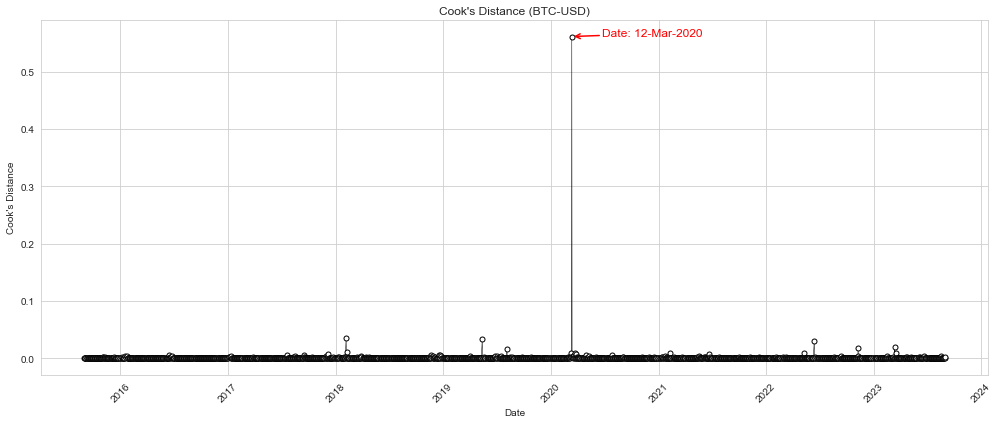

Observation with highest model influence for BTC-USD: 2020-03-12 00:00:00


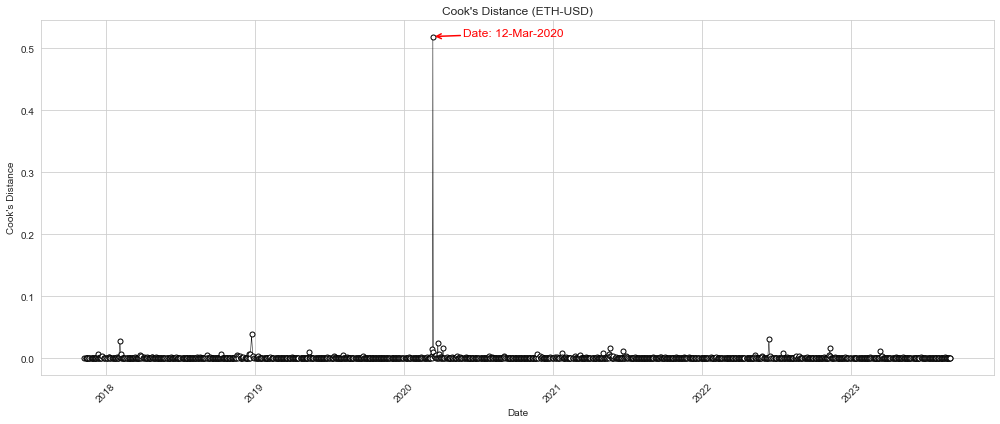

Observation with highest model influence for ETH-USD: 2020-03-12 00:00:00


In [155]:
def model_influence(model, crypto_df):
    # Calculate Cook's distance
    infl = model.get_influence()
    cook_d = infl.cooks_distance[0]  # Cook's distance is the first element in the tuple
    cook_df = pd.DataFrame({'Date': crypto_df.index, "CooksDistance": cook_d})
    idx_max = cook_df["CooksDistance"].idxmax()
    max_cook = cook_df["CooksDistance"].max()
    date_max = crypto_df.index[idx_max]
    


    # plot
    plt.figure(figsize=(14, 6))
    plt.plot(cook_df['Date'], cook_df["CooksDistance"], markeredgecolor='k', marker = 'o', markersize=5,
             markerfacecolor='white', linestyle='-', color='black',
             linewidth=0.5)
    
    plt.annotate(f"Date: {date_max.strftime('%d-%b-%Y')}", (date_max, max_cook),
             xytext=(30, 0), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', lw=1.5, color='red', shrinkA=0),
             fontsize=12, color='red')

    plt.title(f"Cook's Distance ({crypto_df.columns[0]})")
    plt.xlabel('Date')
    plt.ylabel("Cook's Distance")
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.savefig(f"cooksDistance{crypto_df.columns[0]}.jpeg", dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Observation with highest model influence for {crypto_df.columns[0]}: {date_max}")
                            
model_influence(BTC_model, BTC)
model_influence(ETH_model, ETH)

In [152]:
timestamp = BTC.index[1097]
timestamp.strftime('%d-%b-%Y')
# datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')

'12-Mar-2020'

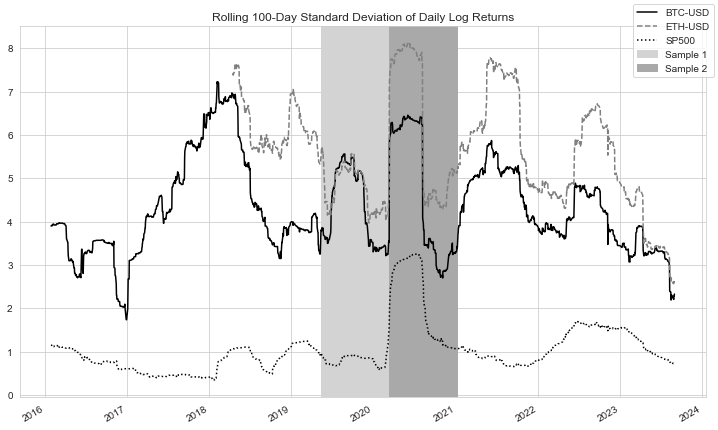

In [37]:
def plot_volatility(df1, df2, col1, col2, col3, n=100):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_title('Rolling 100-Day Standard Deviation of Daily Log Returns')

    df1[col1].rolling(n).std().plot(label=col1, alpha=1, c='black', ax=ax)
    df2[col2].rolling(n).std().plot(label=col2, alpha=1, c='gray', style='--', ax=ax)
    df1[col3].rolling(n).std().plot(label=col3, alpha=1, c='black', style=':', ax=ax)
    # Shade the first time period in light grey
    ax.axvspan('2019-05-15', '2020-03-11', alpha=1, color='lightgrey', label='Sample 1')

    # Shade the second time period in dark grey
    ax.axvspan('2020-03-12', '2021-01-05', alpha=1, color='darkgrey', label='Sample 2')
#     fig.tight_layout()
    fig.legend()
    fig.tight_layout()

    plt.savefig('std_dev_chart.jpeg', dpi=300, bbox_inches='tight')

    plt.show()


plot_volatility(BTC, ETH, 'BTC-USD', 'ETH-USD', 'SP500')

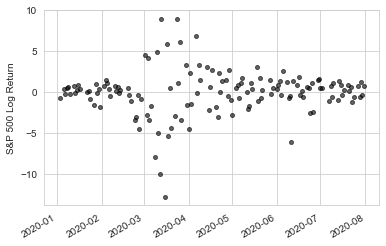

In [467]:
BTC.loc['2020-01-01':'2020-08-01', 'SP500'].plot(style='o', c = 'black', markersize=4, alpha=0.6)
plt.ylabel('S&P 500 Log Return')
plt.show()

In [258]:
BTC.loc['2020-03-01':'2020-03-31', 'SP500']

2020-03-02     4.501087
2020-03-03    -2.851053
2020-03-04     4.133635
2020-03-05    -3.451073
2020-03-06    -1.720100
2020-03-09    -7.901039
2020-03-10     4.821508
2020-03-11    -5.010286
2020-03-12    -9.994485
2020-03-13     8.880836
2020-03-16   -12.765214
2020-03-17     5.822629
2020-03-18    -5.322234
2020-03-19     0.469685
2020-03-20    -4.432763
2020-03-23    -2.973149
2020-03-24     8.968316
2020-03-25     1.146900
2020-03-26     6.054383
2020-03-27    -3.426781
2020-03-30     3.296662
2020-03-31    -1.614238
Name: SP500, dtype: float64

In [41]:
print(BTC['SP500'].idxmin(), BTC['SP500'].min())

2020-03-16 00:00:00 -12.765214115647328


In [42]:
print(BTC['BTC-USD'].idxmin(), BTC['BTC-USD'].min())

2020-03-12 00:00:00 -46.4730175339773


In [43]:
print(ETH['ETH-USD'].idxmin(), ETH['ETH-USD'].min())

2020-03-12 00:00:00 -55.073174382201074


In [240]:
def get_subSamples_and_regress(df, col, date='2020-03-12', n=200):
    df_1 = df[df.index < date].tail(200).copy() #gets the n observations before the given date
    df_2 = df[df.index >= date].head(200).copy() #gets the n observations after and incl. the given date
    df_joined = df_1.append(df_2)
    df_joined.sort_index(inplace=True)

    model_1 = run_lin_reg(df_1, col)
    model_2 = run_lin_reg(df_2, col)
    model_joined = run_lin_reg(df_joined, col)
    
    return df_1, df_2, model_1, model_2, model_joined


BTC subsample regressions:

In [241]:
BTC_1, BTC_2, BTC_model1, BTC_model2, BTC_modelJoined= get_subSamples_and_regress(BTC, 'BTC-USD')

Results for BTC-USD:
                             OLS Regression Results                            
Dep. Variable:               y_actual   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7418
Date:                Thu, 12 Oct 2023   Prob (F-statistic):              0.390
Time:                        13:01:16   Log-Likelihood:                -577.16
No. Observations:                 200   AIC:                             1158.
Df Residuals:                     198   BIC:                             1165.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5399      0.5

ETH subsample regressions:

In [242]:
ETH_1, ETH_2, ETH_model1, ETH_model2, ETH_modelJoined = get_subSamples_and_regress(ETH, 'ETH-USD')

Results for ETH-USD:
                             OLS Regression Results                            
Dep. Variable:               y_actual   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     4.203
Date:                Thu, 12 Oct 2023   Prob (F-statistic):             0.0417
Time:                        13:01:17   Log-Likelihood:                -601.39
No. Observations:                 200   AIC:                             1207.
Df Residuals:                     198   BIC:                             1213.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9255      0.6

In [421]:
def plot_sub_sample_reg_resid(df_samp1, df_samp2, save=False, constant=True):
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

    for i, df in enumerate([df_samp1, df_samp2]):
        row = 0

        col = i % 2
        if constant==True:
            axes[col].scatter(df['x'], df['y_actual'], c = 'black', marker = 'o', s=8, alpha=1,
                               label = 'Data')
            axes[col].plot(df['x'], df['y_hat'], color='red', linewidth=1, label='Regression Line')
            axes[col].set_title(f'Scatter Plot with Regression Line for Sample {i+1} ({df.columns[0]})')
        else:
            axes[col].scatter(df['x'], df['y_actual'], c = 'black', marker = '.', s=5, alpha=0.5,
                               label = 'Data')
            axes[col].plot(df['x'], df['y_hat_no_const'], color='red', linewidth=1, label='Regression Line')
            axes[col].set_title(f'Scatter Plot with Regression Line for {df.columns[0]} (no constant)')
        
        axes[col].set_xlabel('x')
        axes[col].set_ylabel('Y')
        axes[col].legend()


    plt.tight_layout()
    if save==True:
        if constant==True:
            plt.savefig(f"subsampRegression{df.columns[0]}", dpi=300, bbox_inches='tight')
        else: 
            plt.savefig(f"regressionNoConstant", dpi=300, bbox_inches='tight')
            
    plt.show()

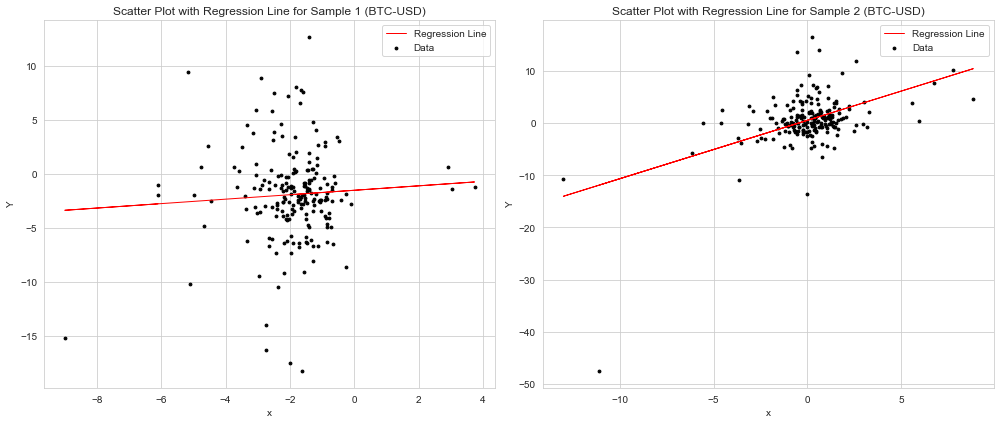

In [409]:
plot_sub_sample_reg_resid(BTC_1, BTC_2, save=True)

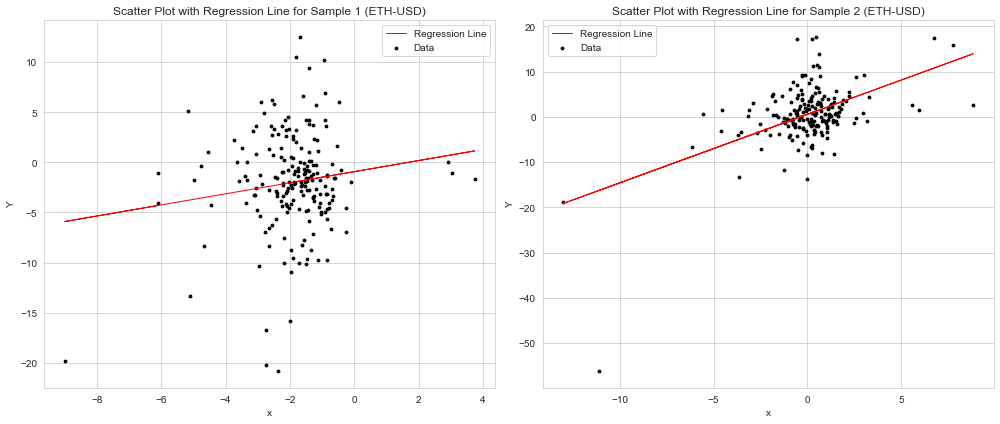

In [410]:
plot_sub_sample_reg_resid(ETH_1, ETH_2, save=True)

In [250]:
def chow_test(model_1, model_2, model_joined, crypto_name): 
    
    # calculate sum of squared residuals for each subsample
    rss_1 = model_1.ssr
    rss_2 = model_2.ssr
    # calculate the sum of squared residuals for the joined period
    rss = model_joined.ssr
    # calculate degrees of freedom
    k = 2  # no. of model parameters
    n = model_joined.nobs #no. observations
    df1 = k
    df2 = n - (2 * k)

    # calculate Chow test statistic
    numerator = (rss - (rss_1 + rss_2)) 
    denominator = (rss_1 + rss_2) 
    f_statistic = (numerator / denominator) * (df2/df1)
    
    # calculate critical value from F distribution
    alpha = 0.05  # significance level
    critical_value = f.ppf(1 - alpha, df1, df2)
    p_value = 1-stats.f.cdf(f_statistic, df1, df2)
    
    # compare F-statistic to critical value
    print(f"{crypto_name}:")
    print('p value: ', round(p_value, 3))
    print('f stat: ', round(f_statistic, 3))
    print('critical value: ', round(critical_value,3))


    if f_statistic > critical_value:
        print("\nThere is a significant structural break.")
    else:
        print("No significant structural break.")


In [251]:
chow_test(BTC_model1, BTC_model2, BTC_modelJoined, 'BTC')

BTC:
p value:  0.001
f stat:  6.647
critical value:  3.019

There is a significant structural break.


In [254]:
chow_test(ETH_model1, ETH_model2, ETH_modelJoined, 'ETH')

ETH:
p value:  0.018
f stat:  4.075
critical value:  3.019

There is a significant structural break.


F-critical:

In [252]:
f.ppf(1 - 0.05, 1, 198)

3.8888529328918806

# g) 
repeat c) without a constant

In [269]:
BTC_model_no_const = run_lin_reg(BTC, 'BTC-USD', constant=False)
ETH_model_no_const = run_lin_reg(ETH, 'ETH-USD', constant=False)

Results for BTC-USD:
                                  OLS Regression Results                                
Dep. Variable:               y_actual   R-squared (uncentered):                   0.206
Model:                            OLS   Adj. R-squared (uncentered):              0.206
Method:                 Least Squares   F-statistic:                              504.2
Date:                Thu, 12 Oct 2023   Prob (F-statistic):                    1.92e-99
Time:                        19:24:21   Log-Likelihood:                         -5579.2
No. Observations:                1941   AIC:                                  1.116e+04
Df Residuals:                    1940   BIC:                                  1.117e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------

F-critical:

In [287]:
f.ppf(1-0.05, 1, 1941-1)

3.846256626117546

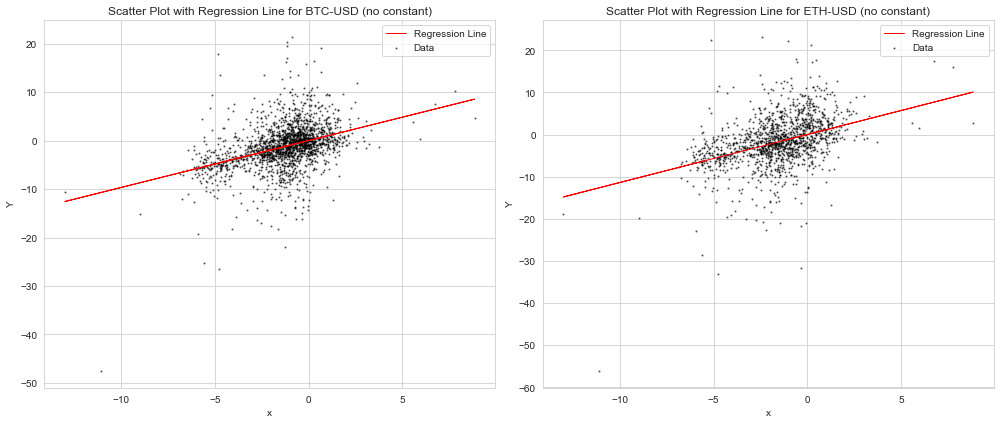

In [423]:
plot_sub_sample_reg_resid(BTC, ETH, constant=False, save=True)   

In [325]:
def log_likelihood_ratio_test(crypto_name, null_model, alt_model, alpha=0.05):

    llfNull = null_model.llf  # log-likelihood of model A
    llfAlt = alt_model.llf  # log-likelihood of model B

    # compute the test stat (log-likelihood ratio)
    log_likelihood_ratio = -2 * (llfNull - llfAlt)

    # chi-squared test with one degree of freedom
    df = 1  
    p_value = 1 - chi2.cdf(log_likelihood_ratio, df)
    print(f"P-value for {crypto_name}: {p_value}")
    # Compare the p-value to the significance level
    if p_value < alpha:
        result = "Reject the null hypothesis (H0). The alternative model is a better fit."
    else:
        result = "Fail to reject the null hypothesis. The null model is as good as the alternative model."

    return result

In [326]:
log_likelihood_ratio_test('BTC', BTC_model, BTC_model_no_const)

P-value for BTC: 1.0


'Fail to reject the null hypothesis. The null model is as good as the alternative model.'

In [328]:
log_likelihood_ratio_test('ETH', ETH_model, ETH_model_no_const)

P-value for ETH: 1.0


'Fail to reject the null hypothesis. The null model is as good as the alternative model.'

AIC vs BIC

In [334]:
def aic_bic(crypto_name, modelA, modelB):
    print(crypto_name)
    print(f'AIC:\tModel1: {modelA.aic}\tModel2: {modelB.aic}')
    print(f'BIC:\tModel1: {modelA.bic}\tModel2: {modelB.bic}')

In [473]:
aic_bic('\t\t\t\tBTC\n', BTC_model, BTC_model_no_const)

				BTC

AIC:	Model1: 11160.353636930831	Model2: 11160.348631748755
BIC:	Model1: 11171.49555409717	Model2: 11165.919590331923


In [474]:
aic_bic('\t\t\t\tETH\n', ETH_model, ETH_model_no_const)

				ETH

AIC:	Model1: 8751.849180576648	Model2: 8753.815262656424
BIC:	Model1: 8762.344765740183	Model2: 8759.063055238192


# Other Code/Misc. Charts

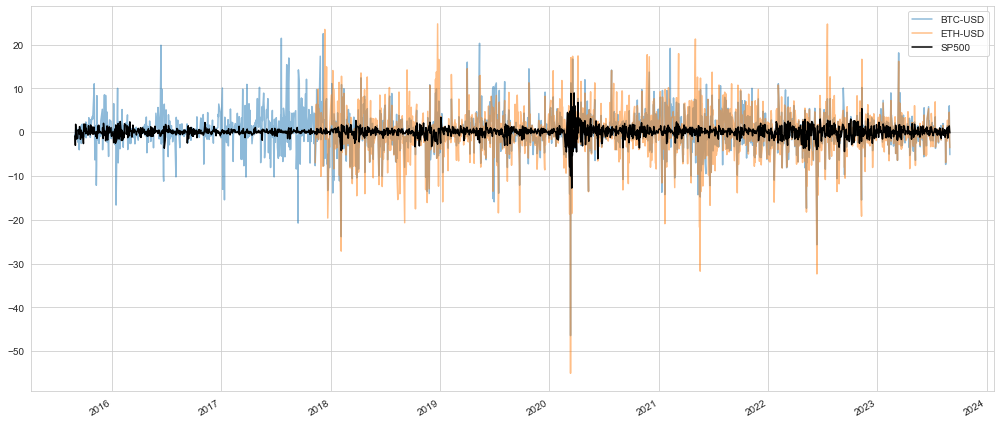

In [369]:
fig, ax = plt.subplots(figsize=(14, 6))

BTC['BTC-USD'].plot(alpha=0.5, ax=ax)
ETH['ETH-USD'].plot(alpha=0.5, ax=ax)

BTC['SP500'].plot(c='black', ax=ax)
ax.legend()
fig.tight_layout()


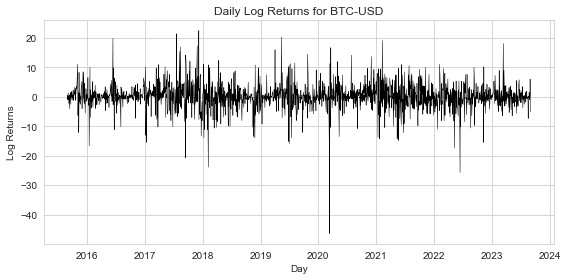

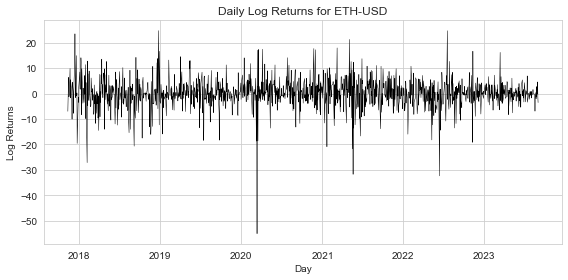

In [372]:
def plot_daily_log_returns(df, column_name):

    fig, ax = plt.subplots(figsize=(8, 4))

    # plot daily log returns as a line
    ax.plot(df[column_name], color='black', linewidth=0.5)

    # add labels and title
    ax.set_xlabel('Day')
    ax.set_ylabel('Log Returns')
    ax.set_title(f'Daily Log Returns for {column_name}')

    # customize tick labels
    ax.tick_params(axis='both', which='both', labelsize=10)

    # Customize the appearance of the plot
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.tight_layout()
    plt.show()
    
plot_daily_log_returns(BTC, 'BTC-USD')
plot_daily_log_returns(ETH, 'ETH-USD')

**Log Excess Returns for BTC, ETH and S&P 500**

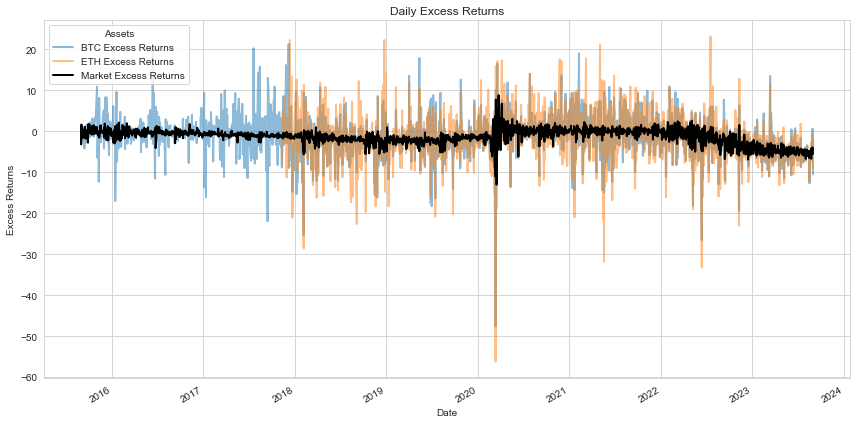

In [385]:
plt.figure(figsize=(12, 6))

plt.title("Daily Excess Returns",)

BTC['y_actual'].plot(label='BTC Excess Returns', alpha=0.5, linestyle='-', linewidth=2)

ETH['y_actual'].plot(label='ETH Excess Returns', alpha=0.5, linestyle='-', linewidth=2)

BTC['x'].plot(label='Market Excess Returns', color='black', linestyle='-', linewidth=2)

plt.legend(loc='upper left', frameon=True, title='Assets')
plt.xlabel("Date")
plt.ylabel("Excess Returns")


plt.tight_layout()
plt.savefig(r"dailyExcessReturns.jpeg", dpi=300, bbox_inches='tight')

plt.show()

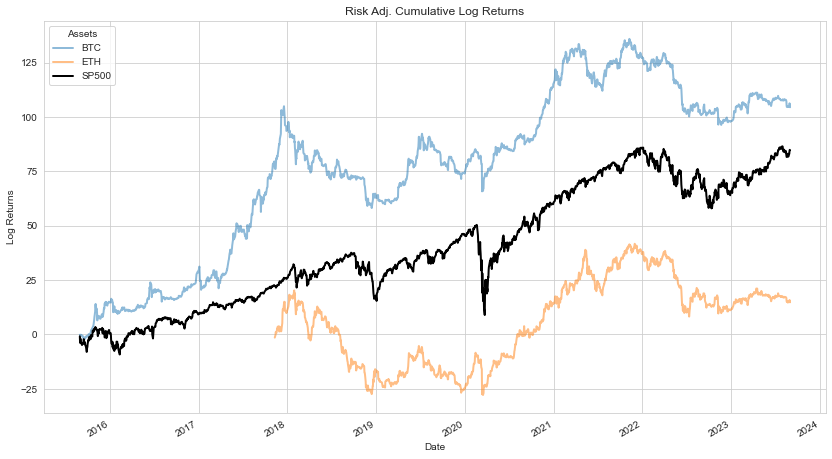

In [395]:
plt.figure(figsize=(14,8))
plt.title("Risk Adj. Cumulative Log Returns")
BTC_cumulative = BTC['BTC-USD'].cumsum()
BTC_ra = (BTC['SP500'].std()/BTC['BTC-USD'].std())

ETH_cumulative = ETH['ETH-USD'].cumsum()
ETH_ra = (BTC['SP500'].std()/ETH['ETH-USD'].std())

(BTC_cumulative*BTC_ra).plot(label='BTC', alpha=0.5, linewidth=2)

(ETH_cumulative*ETH_ra).plot(label='ETH', alpha=0.5, linewidth=2)

# BTC['SP500'].plot(c='black')
BTC['SP500'].cumsum().plot(c='black', linewidth=2)

plt.xlabel("Date")
plt.ylabel("Log Returns")
plt.legend(loc='upper left', frameon=True, title='Assets')
plt.savefig(r"cumulativeLogReturns.jpeg", dpi=300, bbox_inches='tight')

plt.show()


In [464]:
BTC['BTC-USD'].corr(ETH['ETH-USD'])

0.7870153997450345

In [ ]:
BTC['BTC-USD'].corr(BTC['SP500'])

In [461]:
def plot_rolling_correlation(df, crypto, market, n=100):

    rolling_corr = df[crypto].rolling(n).corr(df[market])

    fig, ax = plt.subplots(figsize=(12, 6))

    above_zero = rolling_corr > 0
    below_zero = rolling_corr <= 0

    ax.plot(rolling_corr, label=f'Rolling {n}-day Correlation ({crypto[0:3]} vs {market})', color='k')

    ax.fill_between(rolling_corr.index, 0, rolling_corr, where=above_zero, color='green', alpha=0.5)

    ax.fill_between(rolling_corr.index, 0, rolling_corr, where=below_zero, color='red', alpha=0.5)

    ax.set_title(f'Rolling {n}-day Correlation of {crypto[0:3]} and {market}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Correlation')
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig(f"rollingCorrelation{crypto}.jpeg", dpi=300, bbox_inches='tight')

    plt.show()


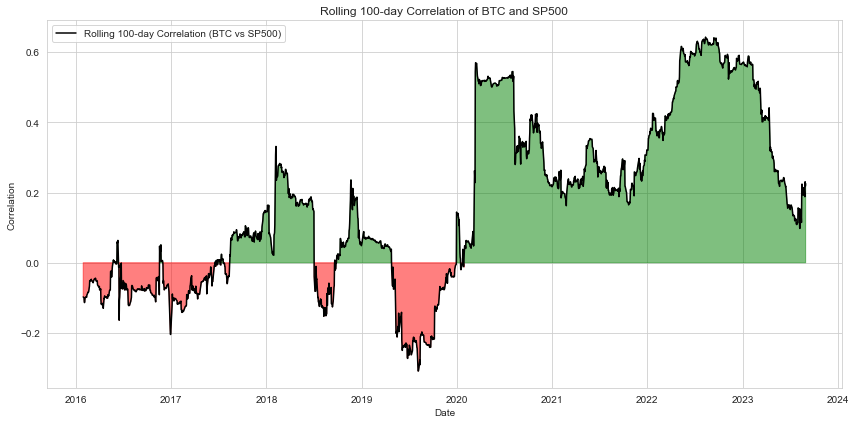

In [462]:
plot_rolling_correlation(BTC, 'BTC-USD', 'SP500')

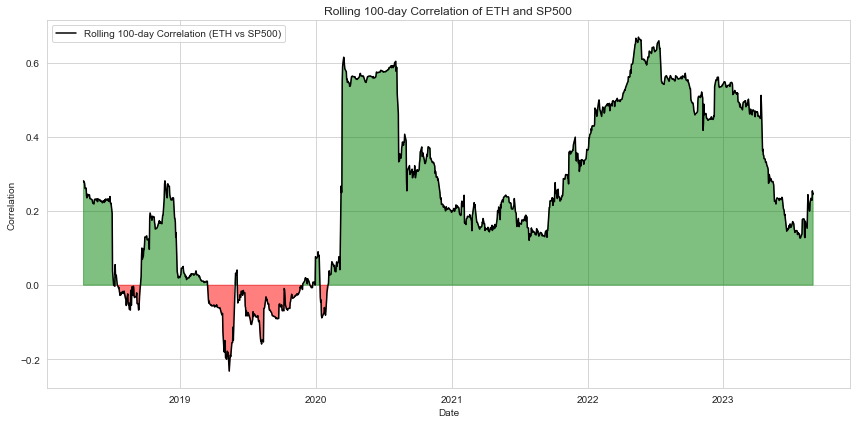

In [463]:
plot_rolling_correlation(ETH, 'ETH-USD', 'SP500')